In [23]:
import os, re, json
import torch, numpy
from collections import defaultdict
from util import nethook
from util.globals import DATA_DIR
from experiments.causal_trace import (
    ModelAndTokenizer,
    layername,
    guess_subject,
    plot_trace_heatmap,
)
from experiments.causal_trace import (
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_token,
    predict_from_input,
    collect_embedding_std,
)
from dsets import KnownsDataset
from matplotlib import pyplot as plt

torch.set_grad_enabled(False)
model_name = "gpt2-xl"  # or "EleutherAI/gpt-j-6B" or "EleutherAI/gpt-neox-20b"
mt = ModelAndTokenizer(
    model_name,
    torch_dtype=(torch.float16 if "20b" in model_name else None),
)
# predict_token(
#     mt,
#     ["Megan Rapinoe plays the sport of", "The Space Needle is in the city of"],
#     return_p=True,
# )
knowns = KnownsDataset(DATA_DIR)  # Dataset of known facts
noise_level = 3 * collect_embedding_std(mt, [k["subject"] for k in knowns])
print(f"Using noise level {noise_level}")

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername, granularity) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
    granularity=100,  # The granularity of restoration
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l, g in states_to_patch:
        patch_spec[l].append((t, g))
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t, g in patch_spec[layer]:
            h[1:, t, g*granularity:(g+1)*granularity] = h[0, t, g*granularity:(g+1)*granularity]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

def trace_important_states(model, num_layers, inp, e_range, answer_t, granularity=100, noise=0.1):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layer_scores = []
            for g in range(model.config.hidden_size // granularity):
                r = trace_with_patch(
                    model,
                    inp,
                    [(tnum, layername(model, layer), g)],
                    answer_t,
                    tokens_to_mix=e_range,
                    noise=noise,
                    granularity=granularity,
                )
                layer_scores.append(r)
            row.append(torch.stack(layer_scores))
        table.append(torch.stack(row))
    return torch.stack(table)

def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, granularity=100
):
    ntoks = inp["input_ids"].shape[1]
    table = []
    for tnum in range(ntoks):
        row = []
        for layer in range(0, num_layers):
            layer_scores = []
            for g in range(model.config.hidden_size // granularity):
                layerlist = [
                    (tnum, layername(model, L, kind), g)
                    for L in range(
                        max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                    )
                ]
                r = trace_with_patch(
                    model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise, granularity=granularity
                )
                layer_scores.append(r)
            row.append(torch.stack(layer_scores))
        table.append(torch.stack(row))
    return torch.stack(table)

def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None, granularity=100
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise, granularity=granularity
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise, granularity=granularity
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            granularity=granularity
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
        granularity=granularity,
    )

def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    modelname=None,
    savepdf=None,
    granularity=100,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt, prompt, subject, samples=samples, noise=noise, window=window, kind=kind, granularity=granularity
    )
    plot_trace_heatmap(result, savepdf, modelname=modelname)
    return result




def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"
        # 获取张量的形状
    token_size, dim1, dim2 = differences.size()

    # 将最后两个维度展平
    differences = differences.view(token_size, dim1 * dim2)
    
    with plt.rc_context():
        fig, ax = plt.subplots(figsize=(14, 8))
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels)
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=10)
        # savepdf =   f"./output/hidden_flow_{kind}_{window}_{result['granularity']}.pdf"
            
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()
            

def plot_all_flow(mt, prompt, subject=None, noise=0.1, modelname=None, granularity=100):
    results = []
    for kind in [None, "mlp", "attn"]:
        result = plot_hidden_flow(
            mt, prompt, subject, modelname=modelname, noise=noise, kind=kind, granularity=granularity
        )
        results.append(result["scores"]) 
    return results   




Loaded dataset with 1209 elements
Using noise level 0.13462981581687927


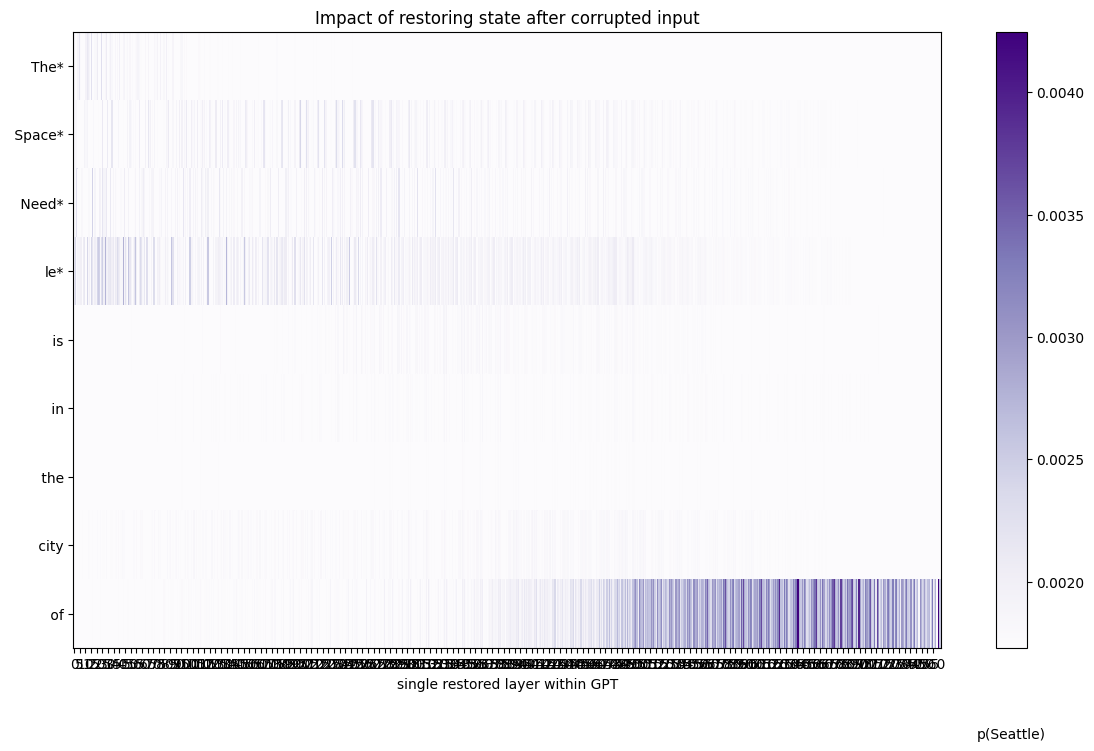

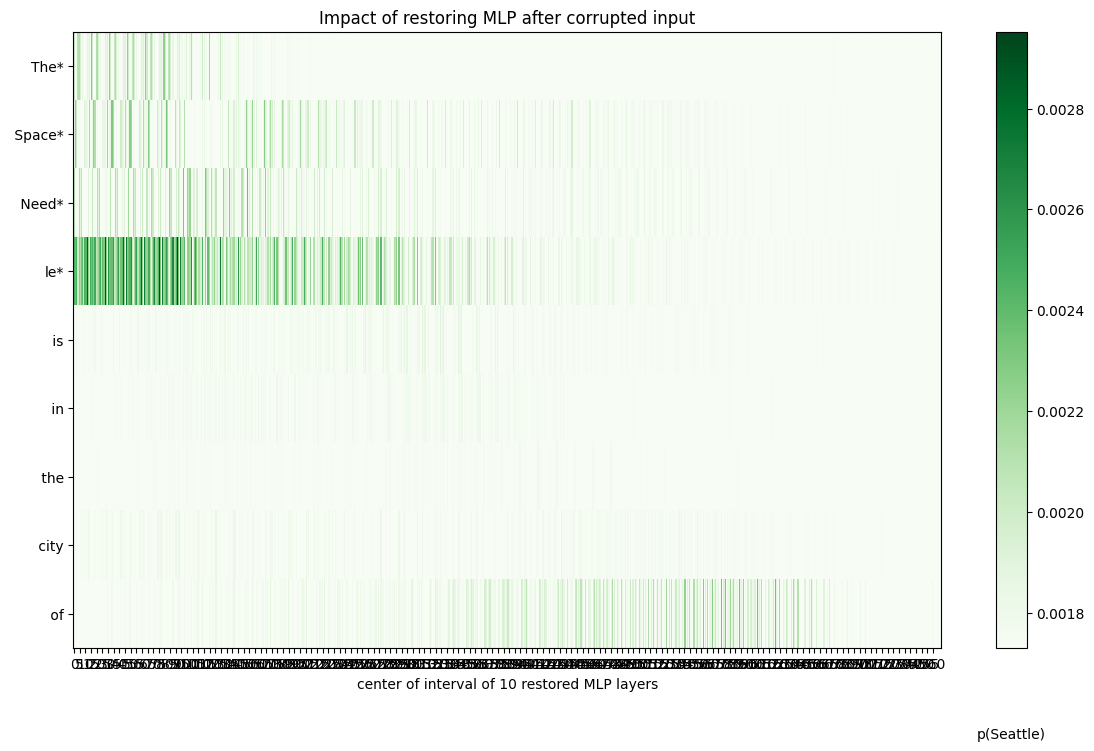

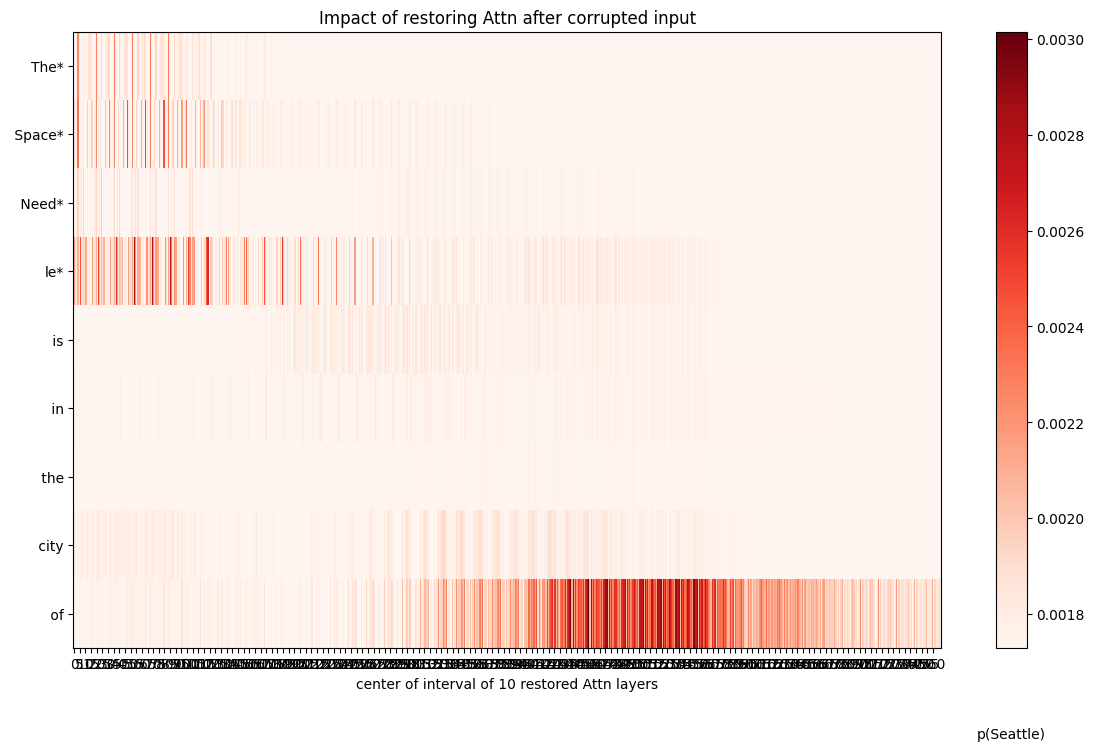

In [2]:
# Example call with granularity
r1 = plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level, granularity=100)


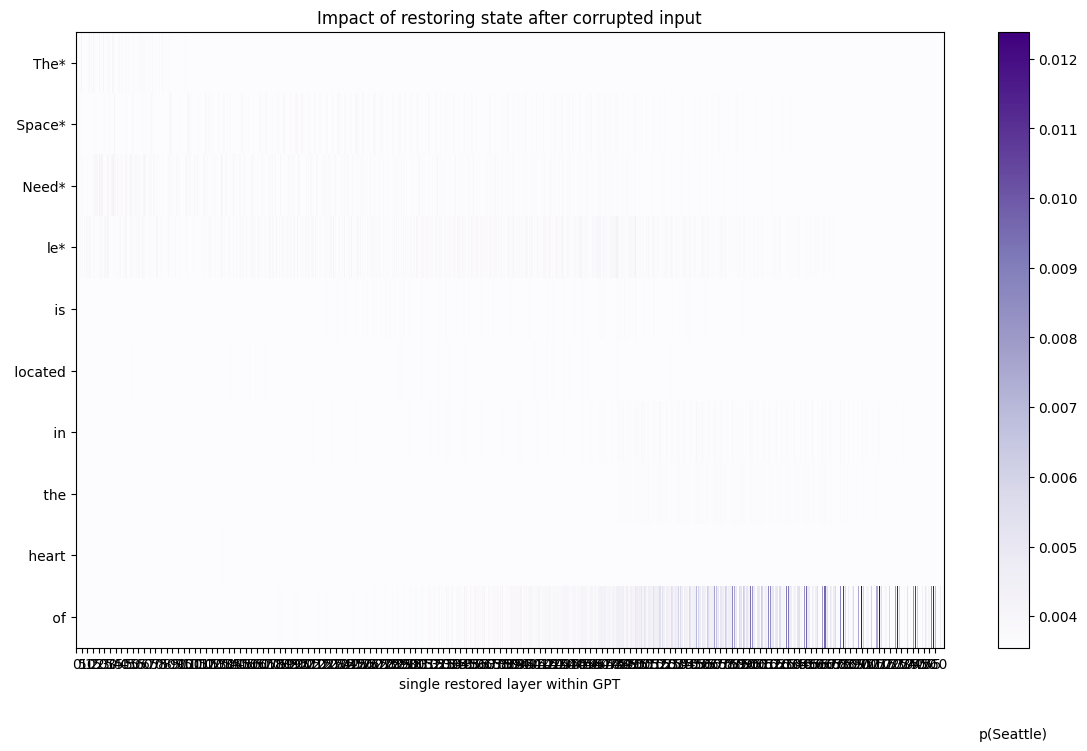

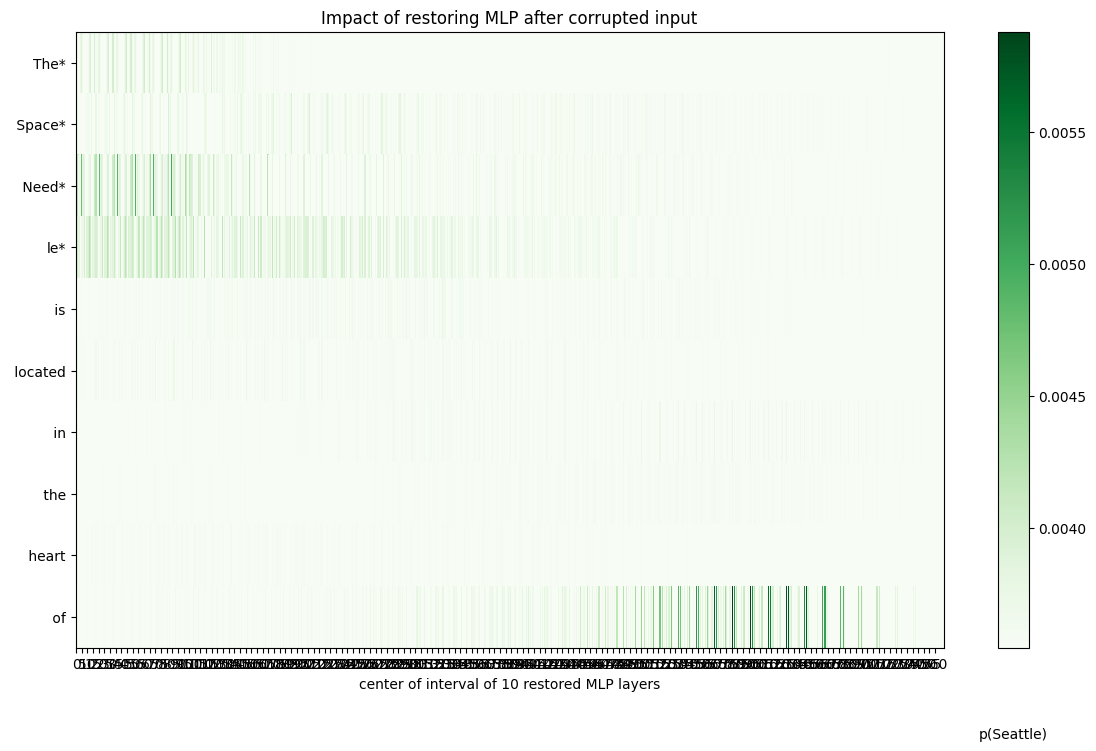

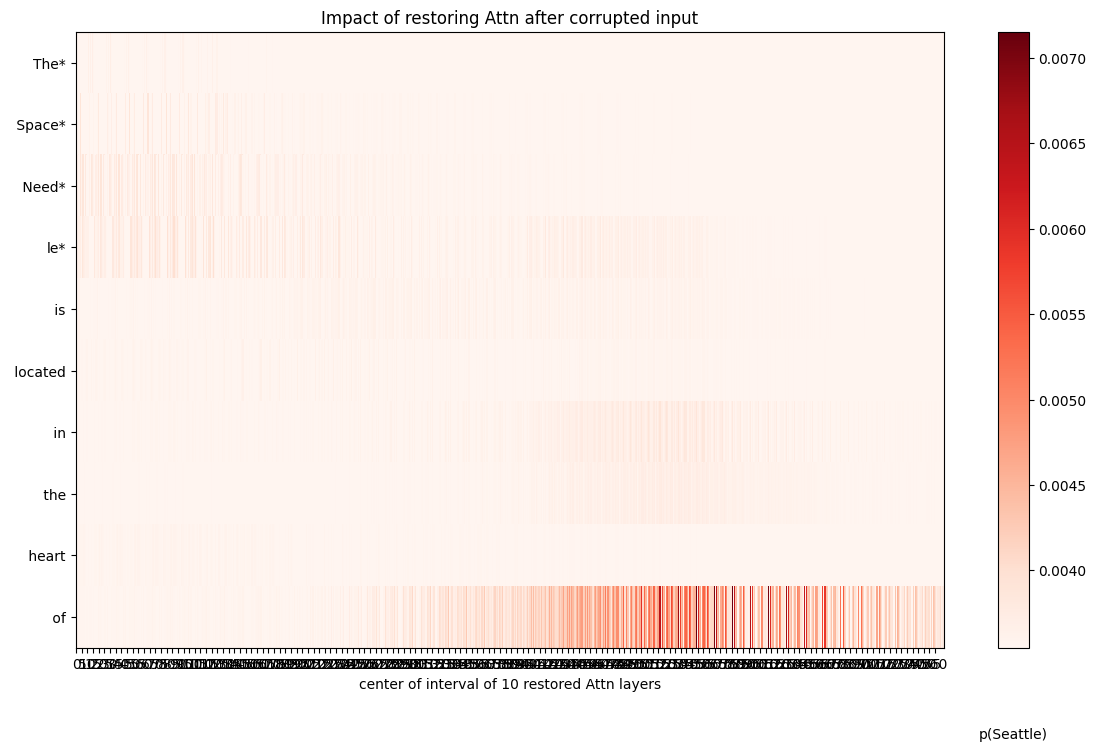

In [3]:
r2 = plot_all_flow(mt, "The Space Needle is located in the heart of", noise=noise_level, granularity=100)


In [4]:
r3 = plot_all_flow(mt, "You can find the Space Needle in central", noise=noise_level, granularity=100)

KeyboardInterrupt: 

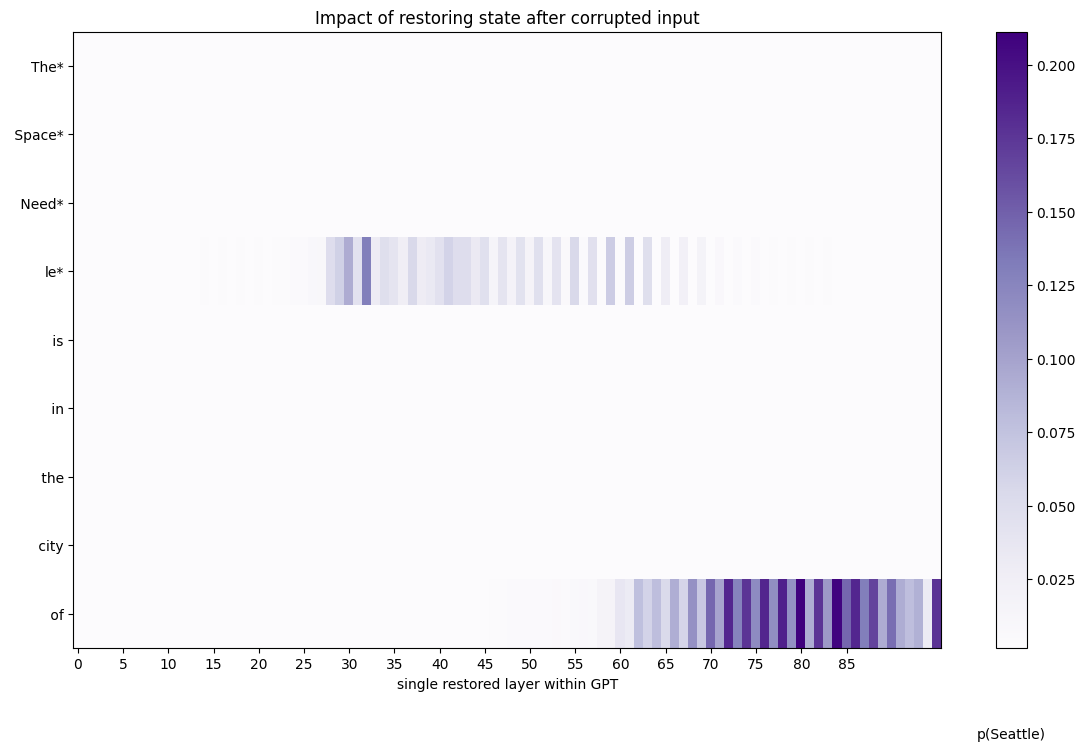

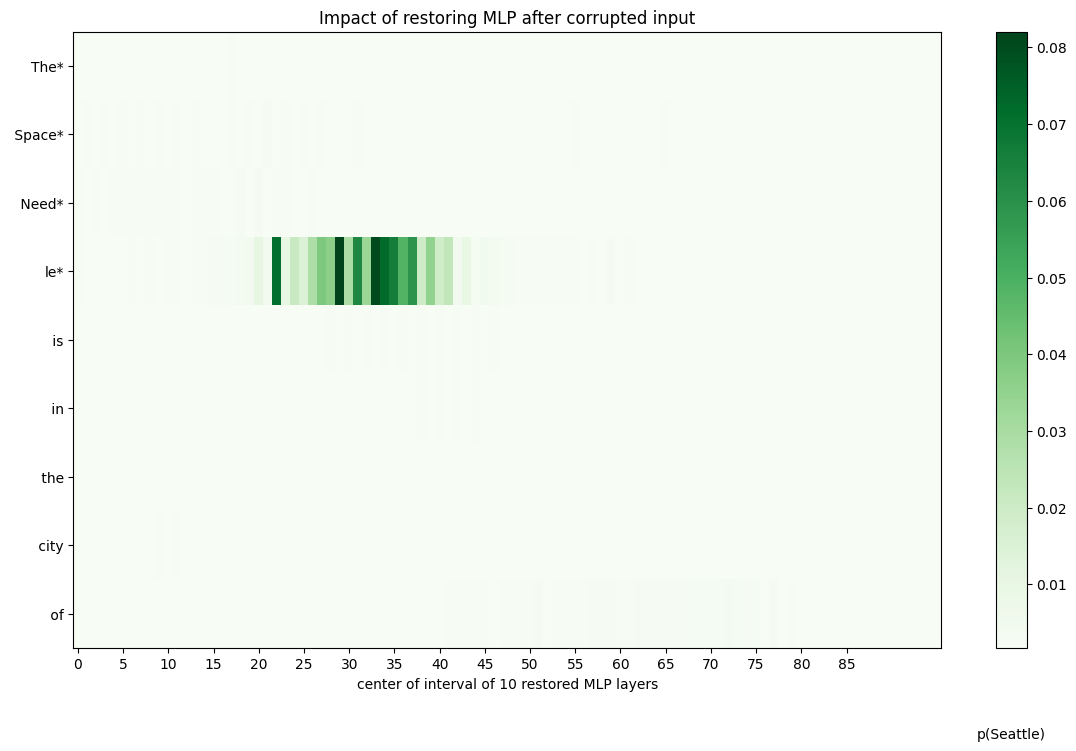

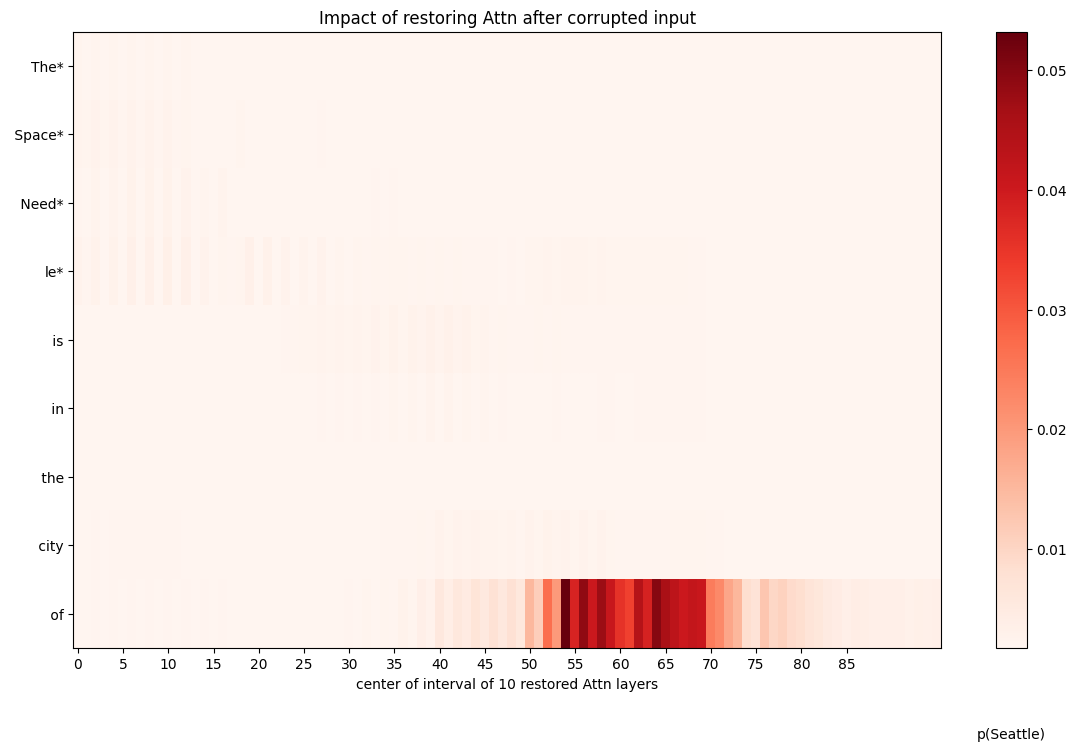

In [24]:
# Example call with granularity
r1 = plot_all_flow(mt, "The Space Needle is in the city of", noise=noise_level, granularity=800)

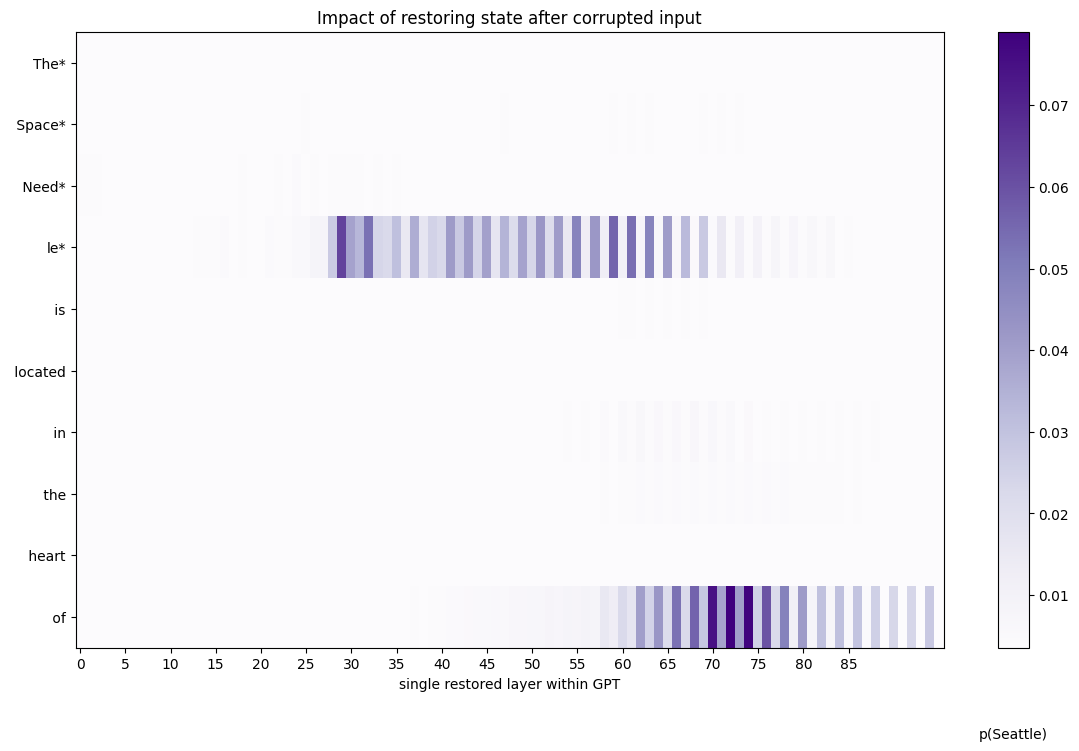

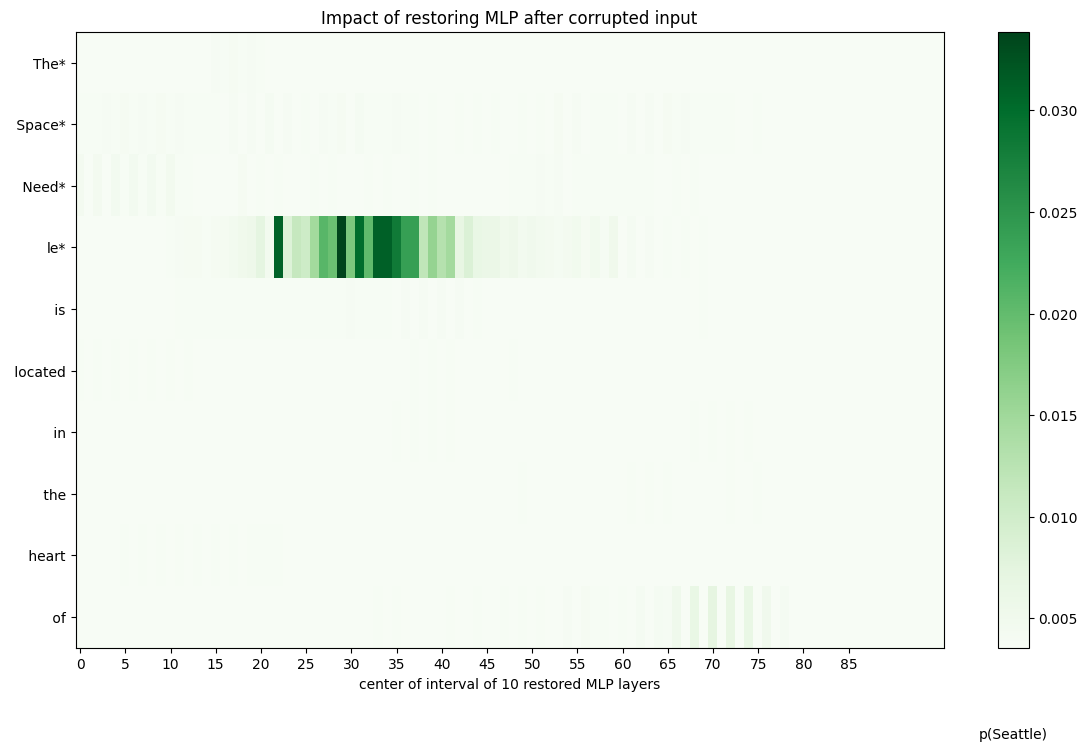

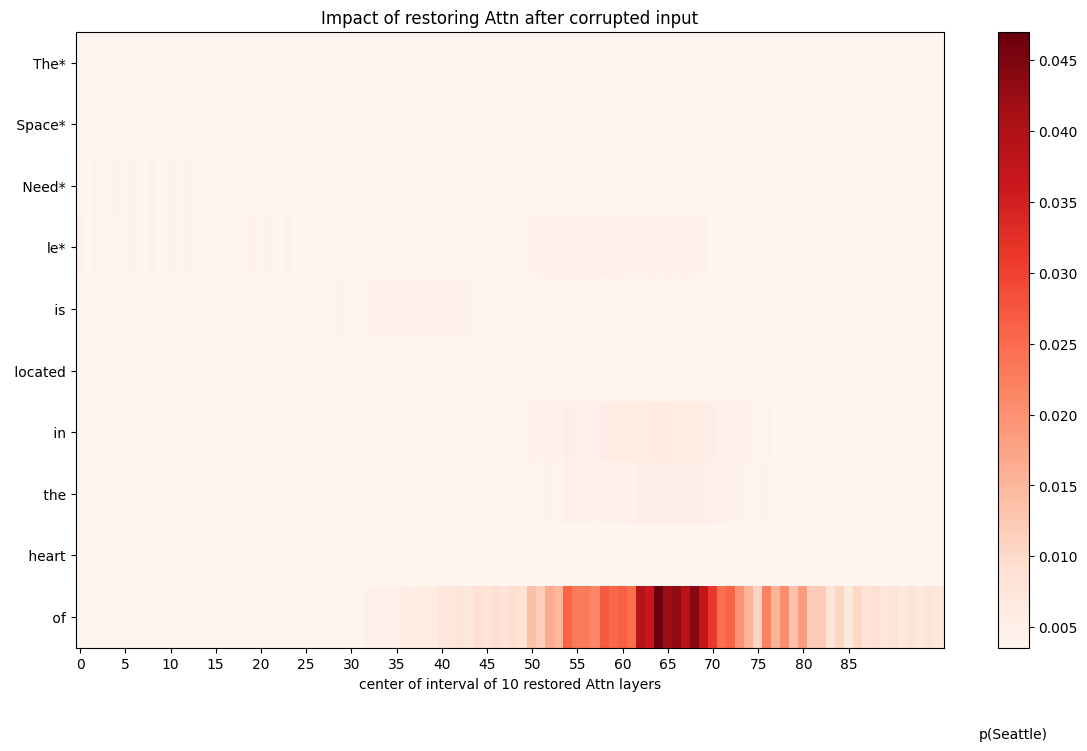

In [25]:
r2 = plot_all_flow(mt, "The Space Needle is located in the heart of", noise=noise_level, granularity=800)

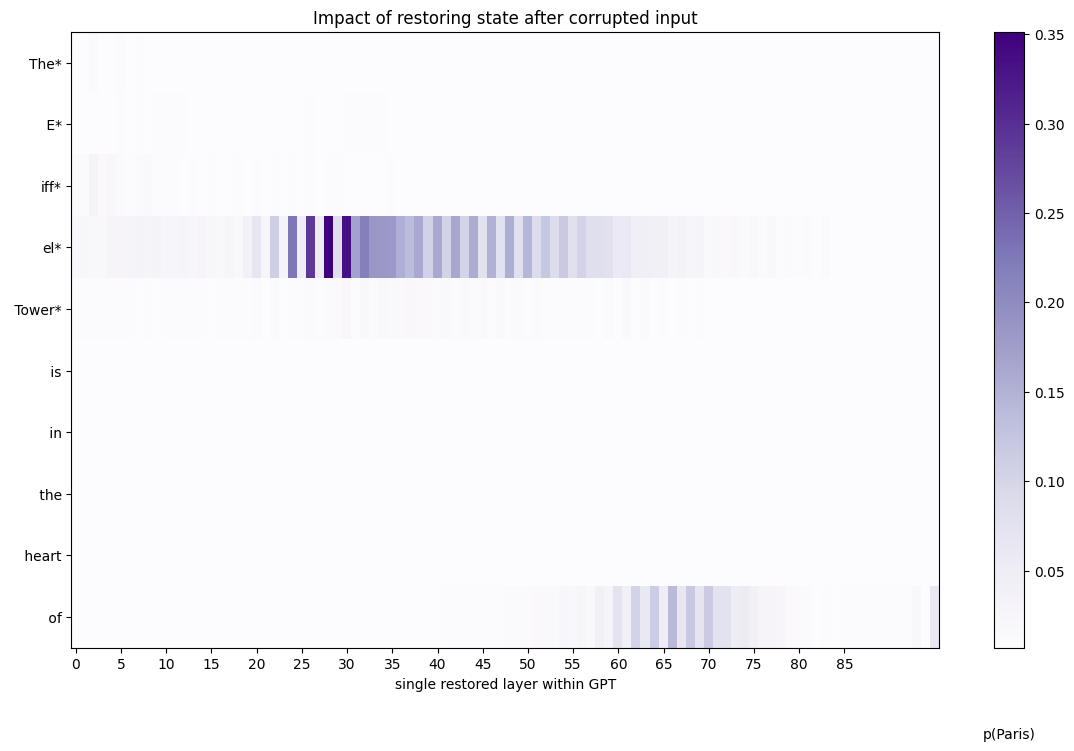

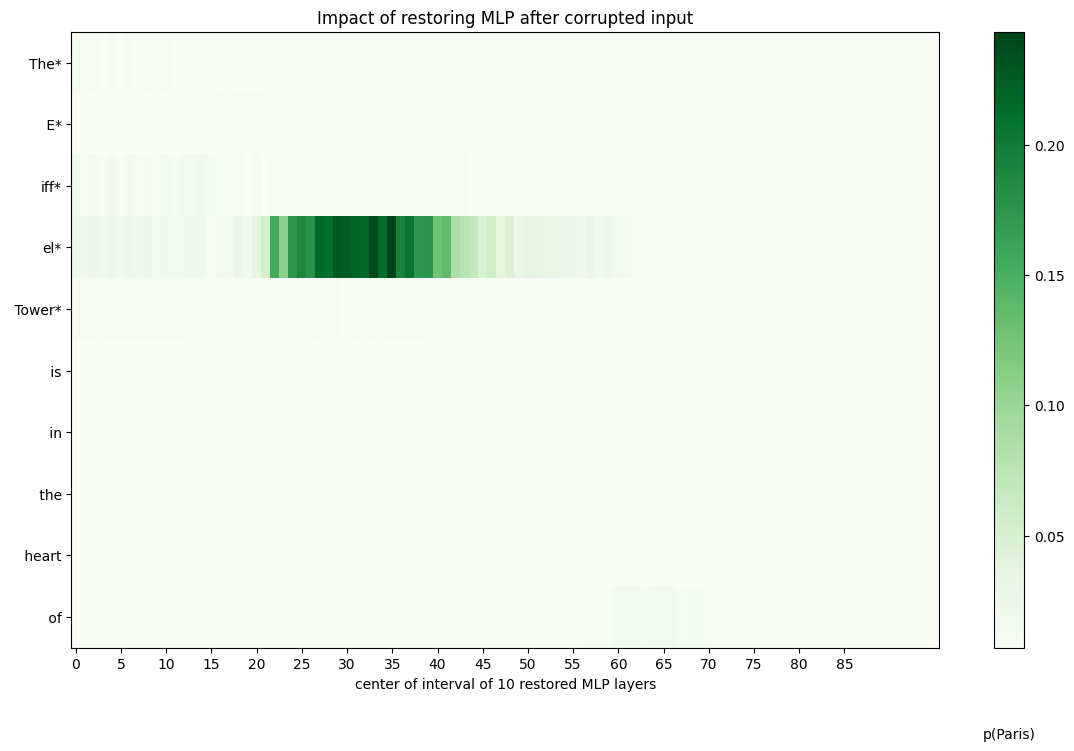

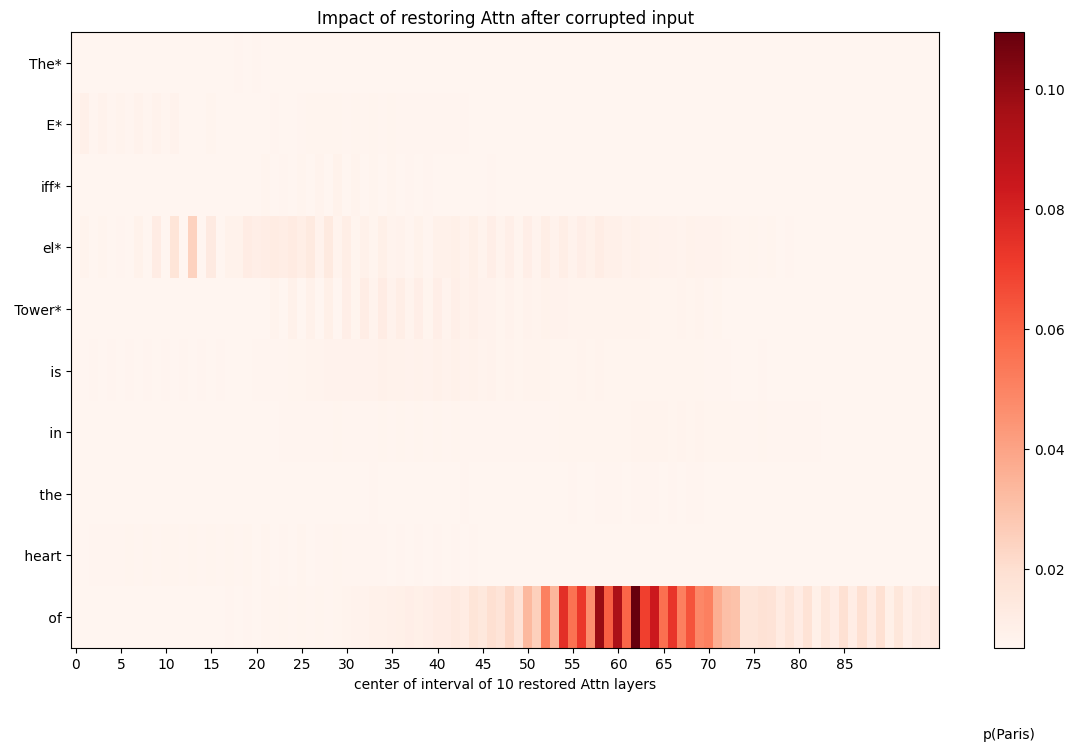

In [35]:
r3 = plot_all_flow(mt, "The Eiffel Tower is in the heart of", noise=noise_level, granularity=800)

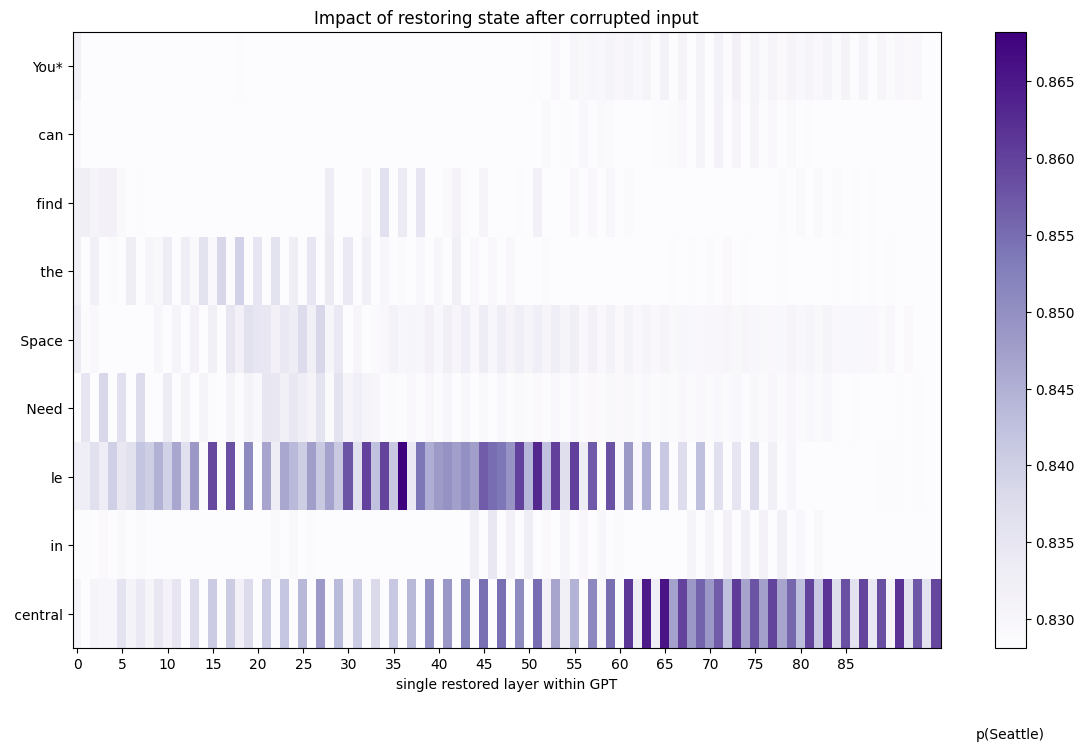

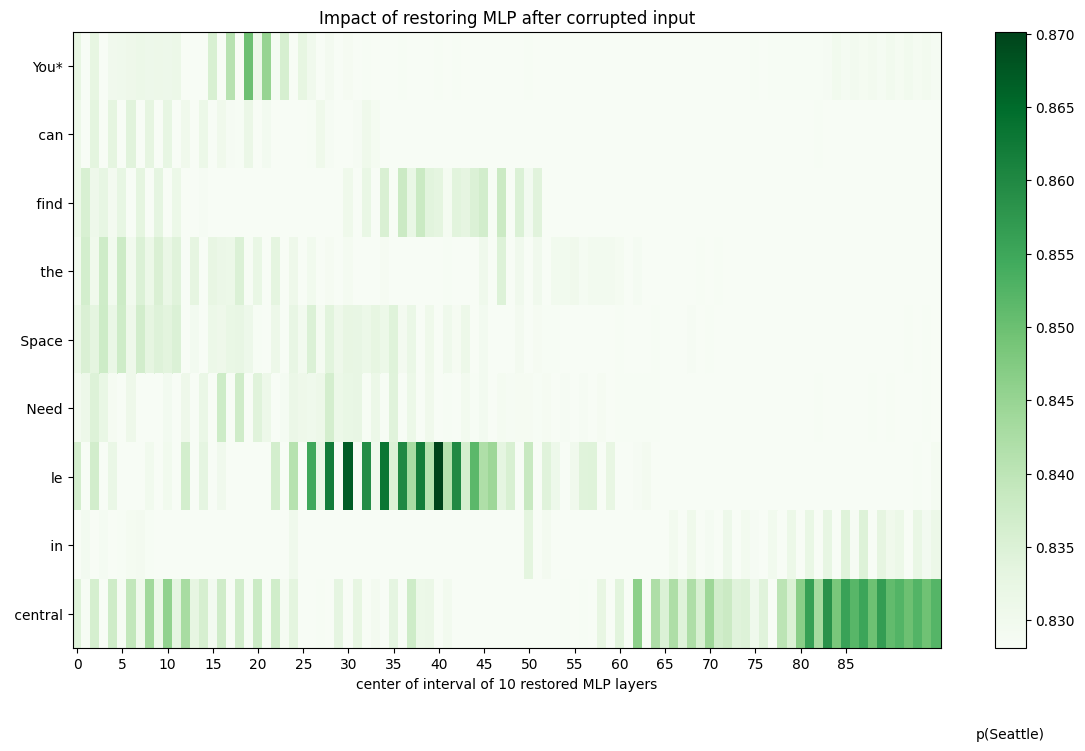

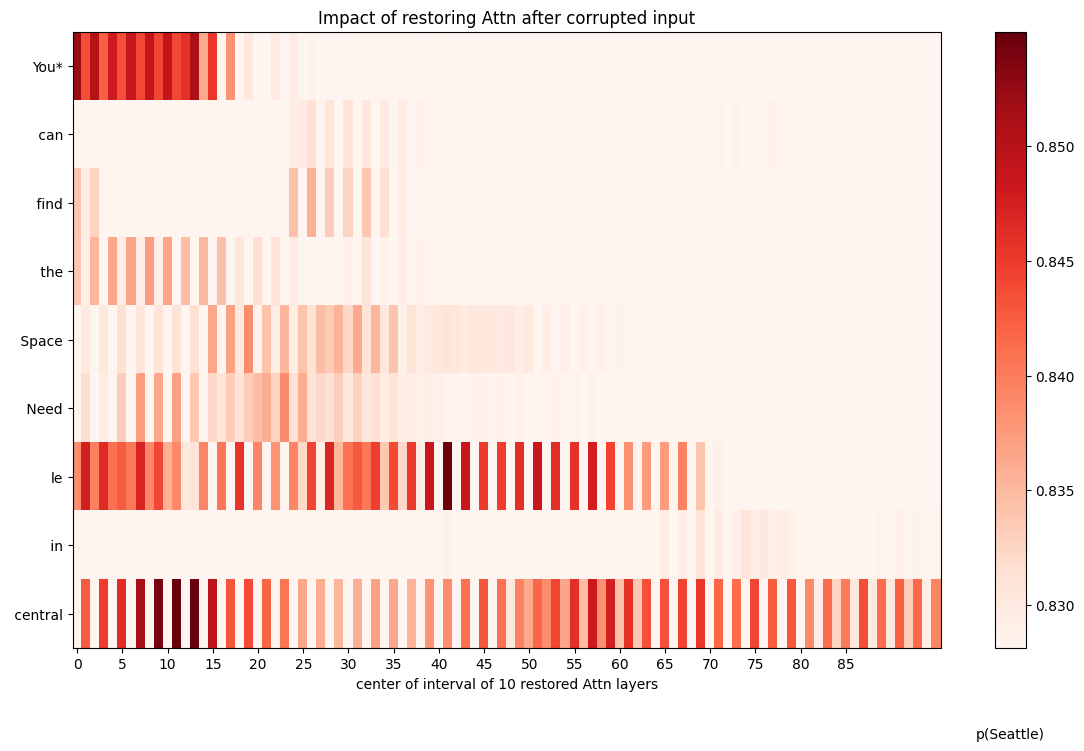

In [37]:
r4 = plot_all_flow(mt, "You can find the Space Needle in central", noise=noise_level, granularity=800)

In [26]:
import torch

def euclidean_distance(r1, r2):
    distances = []
    for i in range(r1.shape[0]):  # For each layer
        distance = torch.norm(r1[i] - r2[i])
        distances.append(distance.item())
    return torch.tensor(distances).mean()




In [27]:
import torch.nn.functional as F

def cosine_similarity_avg(r1, r2):
    similarities = []
    for i in range(r1.shape[0]):  # For each layer
        similarity = F.cosine_similarity(r1[i].unsqueeze(0), r2[i].unsqueeze(0))
        similarities.append(similarity.item())
    return torch.tensor(similarities).mean()





In [29]:
def pearson_correlation_avg(r1, r2):
    correlations = []
    for i in range(r1.shape[0]):  # For each layer
        # Compute mean
        mean_r1 = torch.mean(r1[i])
        mean_r2 = torch.mean(r2[i])
        
        # Compute numerator
        numerator = torch.sum((r1[i] - mean_r1) * (r2[i] - mean_r2))
        
        # Compute denominator
        denominator = torch.sqrt(torch.sum((r1[i] - mean_r1) ** 2) * torch.sum((r2[i] - mean_r2) ** 2))
        
        # Compute correlation
        correlation = numerator / denominator
        correlations.append(correlation.item())
    return torch.tensor(correlations).mean()





In [34]:
print(len(r1))
print(r1[1].shape)
print(r1[1][3].shape)
r1_subject = r1[1][3]
r2_subject = r2[1][3]
# Example usage
distance = euclidean_distance(r1_subject, r2_subject)
print("Euclidean Distance:", distance.item())
# Example usage
similarity = cosine_similarity_avg(r1_subject, r2_subject)
print("Average Cosine Similarity:", similarity.item())
# Example usage
correlation = pearson_correlation_avg(r1_subject, r2_subject)
print("Average Pearson Correlation:", correlation.item())

3
torch.Size([9, 48, 2])
torch.Size([48, 2])
Euclidean Distance: 0.009174938313663006
Average Cosine Similarity: 0.9960556626319885
Average Pearson Correlation: 0.2916666567325592


In [36]:
print(len(r1))
print(r1[1].shape)
print(r1[1][3].shape)
r1_subject = r1[1][3]
r2_subject = r3[1][3]
# Example usage
distance = euclidean_distance(r1_subject, r2_subject)
print("Euclidean Distance:", distance.item())
# Example usage
similarity = cosine_similarity_avg(r1_subject, r2_subject)
print("Average Cosine Similarity:", similarity.item())
# Example usage
correlation = pearson_correlation_avg(r1_subject, r2_subject)
print("Average Pearson Correlation:", correlation.item())

3
torch.Size([9, 48, 2])
torch.Size([48, 2])
Euclidean Distance: 0.06308659166097641
Average Cosine Similarity: 0.9810425639152527
Average Pearson Correlation: 0.25


In [38]:
print(len(r1))
print(r1[1].shape)
print(r1[1][3].shape)
r1_subject = r1[1][3]
r2_subject = r4[1][6]
# Example usage
distance = euclidean_distance(r1_subject, r2_subject)
print("Euclidean Distance:", distance.item())
# Example usage
similarity = cosine_similarity_avg(r1_subject, r2_subject)
print("Average Cosine Similarity:", similarity.item())
# Example usage
correlation = pearson_correlation_avg(r1_subject, r2_subject)
print("Average Pearson Correlation:", correlation.item())

3
torch.Size([9, 48, 2])
torch.Size([48, 2])
Euclidean Distance: 1.1601043939590454
Average Cosine Similarity: 0.9838099479675293
Average Pearson Correlation: 0.125
